# Sound bites

Can we detect sound bites that are evolving?

The NLP will be harder than the time series analysis (i.e. what exactly is a sound bite and how would we represent it). We use some open source data and tools to make a start.

In [1]:
import numpy as np
import pandas as pd

A CSV containing every comment from every politician in the Hansard archive as a .csv

1 million statements and counting...

In [2]:
df = pd.read_csv('./speeches.csv')
df.dropna(inplace=True)
print(len(df))

1088983


Speaker name, transcript and the original .xml file from the archives

In [3]:
df.head()

,date,speaker,text
0,debates2010-01-05a.xml,Philip Hollobone,May I suggest to the Secretary of State that p...
1,debates2010-01-05a.xml,Philip Hollobone,"""If you commit a crime you will be deported fr..."
2,debates2010-01-05a.xml,Jack Straw,I am happy to seek to provide the hon. Gentlem...
3,debates2010-01-05a.xml,Jack Straw,What we want to see is prison made effective. ...
4,debates2010-01-05a.xml,David Miliband,We should certainly have a foreign policy that...


In [4]:
# Ease computational requirements
df = df.loc[500000:]

Compute the day and month from the filename (we can use this for grouping transcripts)

In [6]:
df['day'] = df.date.apply(lambda x: x.lstrip('debates').rstrip('abcdefghijklmno.xml'))
df['month'] = df['day'].apply(lambda x: x[:7])
df.head()

,date,speaker,text,day,month
500000,debates2013-03-12b.xml,David Gauke,‘notes that this Coalition Government has cut ...,2013-03-12,2013-03
500001,debates2013-03-12b.xml,David Gauke,After listening to the speech of,2013-03-12,2013-03
500002,debates2013-03-12b.xml,David Gauke,We might also have thought that the Labour Gov...,2013-03-12,2013-03
500003,debates2013-03-12b.xml,David Gauke,Whatever the differences that may exist on the...,2013-03-12,2013-03
500004,debates2013-03-12b.xml,Alex Cunningham,"At Treasury questions, one of the Minister’s c...",2013-03-12,2013-03


The transcript for each day

In [7]:
daytext = df.groupby('day')['text'].agg(lambda x: ' '.join(x))
daytext.head()

day
2013-03-12    ‘notes that this Coalition Government has cut ...
2013-03-13    In 1997 there were no excess deaths in the mor...
2013-03-14    What steps he is taking to help households imp...
2013-03-18    I want to speak very briefly on the royal char...
2013-03-19    What assessment he has made of the value of th...
Name: text, dtype: object

## Tokenisation

We write some tokenisers for words and sentences. Handling some cases particular to our problem. We want to preserve numbers (so don't split on commas!).

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

In [9]:
def sent_split(s):
    return re.split('(?<!hon)\.(?=\W)', s, re.IGNORECASE)

In [10]:
def tokenizer(s):
    return [xx.strip('()[];-\'`.,"') for xx in s.split(' ') if xx.strip() != '']

In [11]:
def sentence_tokenizer(s):
    return [xx.strip('').lower() for xx in sent_split(s) if xx.strip() != '']

Some words that aren't helpful

In [35]:
from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union([
    'government', 'minister', 'hon', 'friend'
])

We'll use a TFIDF representation, which emphasises words that are used very often on a single day relative to their usage in the entire archive.

In [36]:
# Warning - takes some time!
vec = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words, tokenizer=tokenizer, min_df=2)
vec = vec.fit(daytext)

Function to print the most prominent words for a given sentence and vectorizer.

In [37]:
def top_n_words(text, vec, n=10):
    df = pd.DataFrame(data={
        'token': vec.get_feature_names(),
        'count': vec.transform([text]).toarray()[0],
    })
    return df[df['count']>0].sort_values('count', ascending=False)[:n]

Find context around the word

In [38]:
def word_context(text, word):
    idx = text.lower().index(word)
    return text[idx-100:idx+100]

## See it in action

Let's look at the most recent date in our archive. 

In [88]:
daytext.index[-1]

'2017-04-27'

Now we look at prominent words used that day. No surprises here!

In [100]:
top_n_words(daytext[-1], vec)

,count,token
50502,0.207737,act 2017
525234,0.125958,eu
528482,0.123721,european
1537020,0.119762,uk
190413,0.109696,brexit
610424,0.107632,friend
1514736,0.106157,trade
1514760,0.104083,trade agreement
585496,0.101178,financial services
398774,0.100129,deal


Let's dive deeper. Looks like trade agreements are a hot topic. 

In [95]:
word_context(daytext[-1], 'trade agreement')

'ean businesses do the same in the UK. Financial services is one area for which a bold and ambitious trade agreement will be sought, and we will continue to talk to the industry as we prepare for negot'

# Use of sound bites over time

But have they always been?

In [101]:
import matplotlib.pyplot as plt

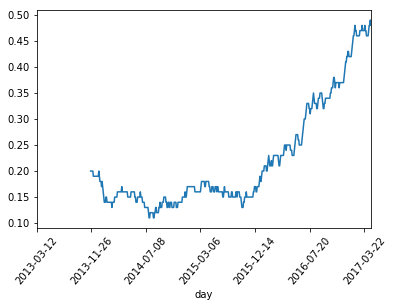

In [104]:
daytext.str.lower().str.contains('trade agreement').rolling(100).mean().plot()
plt.xticks(rotation=50);

Mentions of a trade agreement have exploded :)